In [1]:
import torch
from torch import nn

from tinyai.all import *

set_output()

In [2]:
from datasets import load_dataset
import torchvision.transforms.functional as TF

from tinyai.datasets import DataLoaders, transformi
from tinyai.training import cross_entropy

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [3]:
from tinyai.conv import conv

def get_model():
    return nn.Sequential(
        conv(1,8),
        conv(8, 16),
        conv(16, 32),
        conv(32,64),
        conv(64, 10, act=None),
        nn.Flatten()
    )


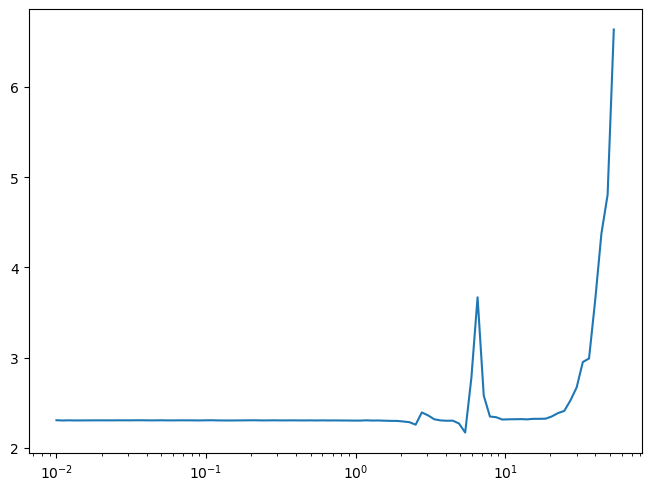

In [6]:
learn = Trainer(get_model(), dls, loss_func=cross_entropy, lr=1e-4)
learn.lr_find(gamma=1.1, start_lr=1e-2)

In [6]:
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc

metrics = MetricsCB(accuracy=MulticlassAccuracy())
metrics.show_train = True
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [metrics, astats]

def get_trainer(lr):
    set_seed(1)
    return Trainer(get_model(), dls, loss_func=cross_entropy, lr=lr, cbs=cbs)


## 0.2

epoch,train,loss,accuracy
0,train,2.3000,0.1159
0,eval,2.2908,0.1620


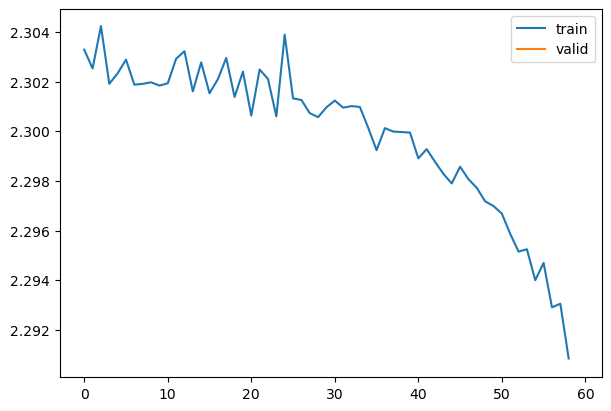

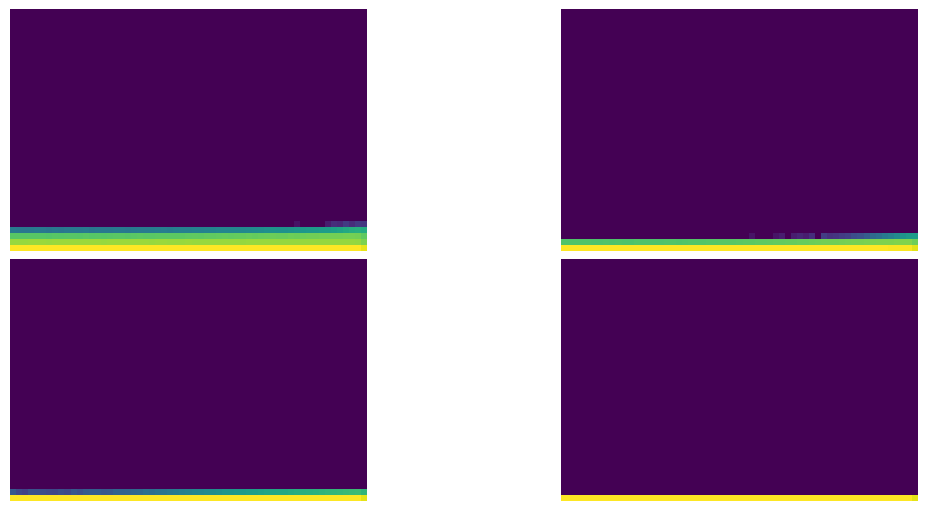

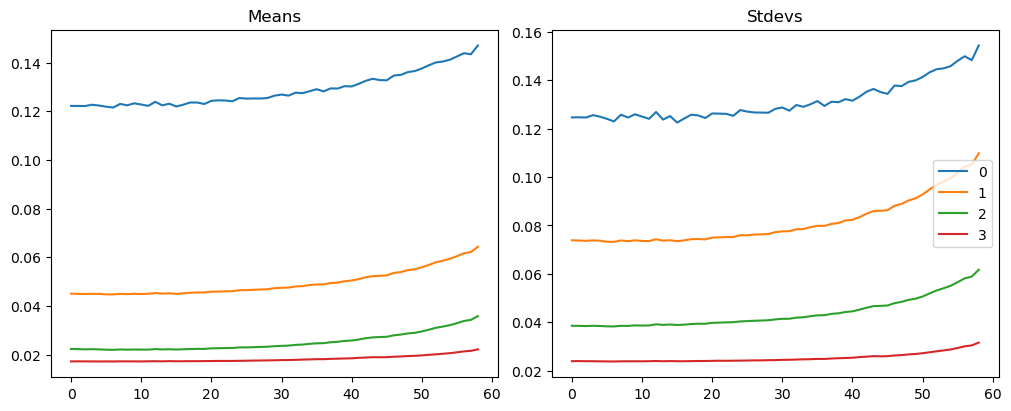

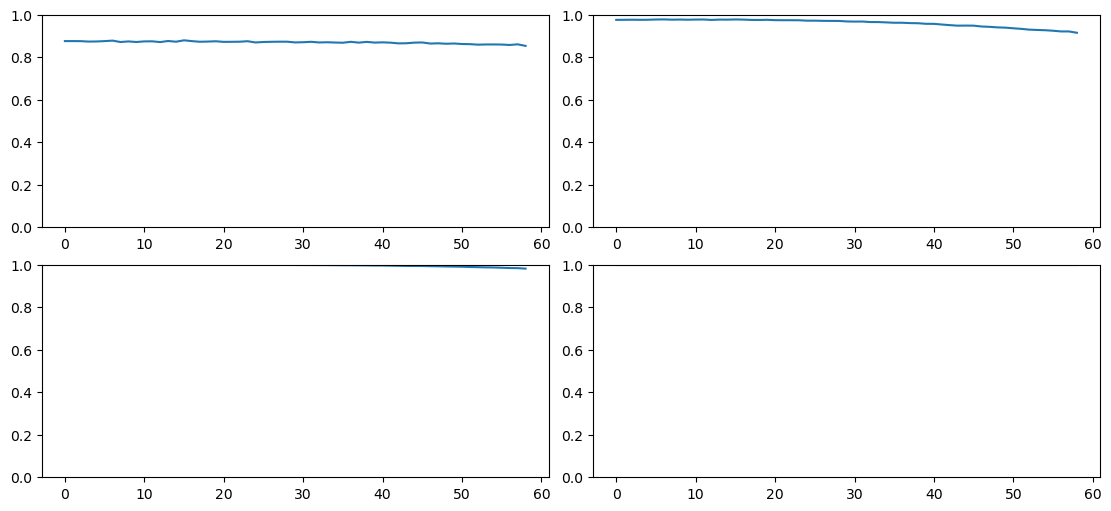

In [9]:
get_trainer(0.2).fit(1)
astats.plot_all()

### 0.4

epoch,train,loss,accuracy
0,train,2.2308,0.1780
0,eval,2.1654,0.2479


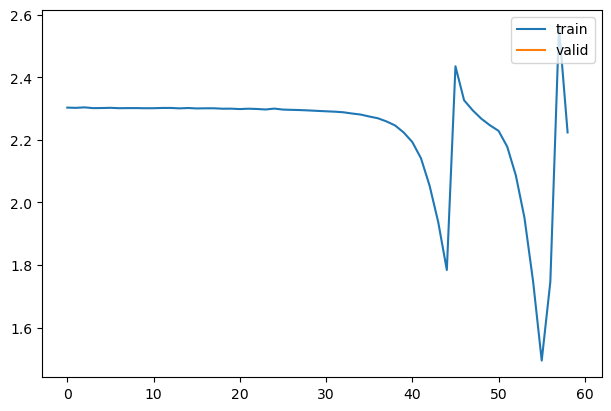

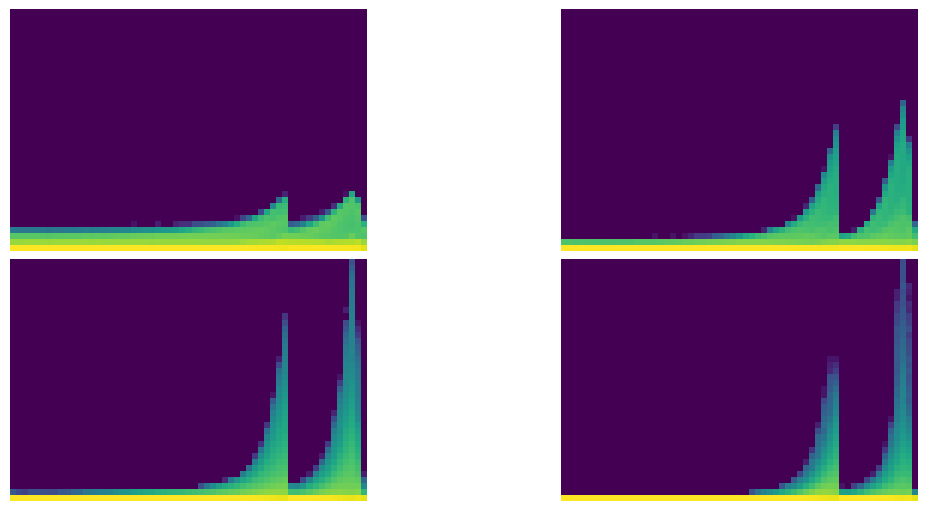

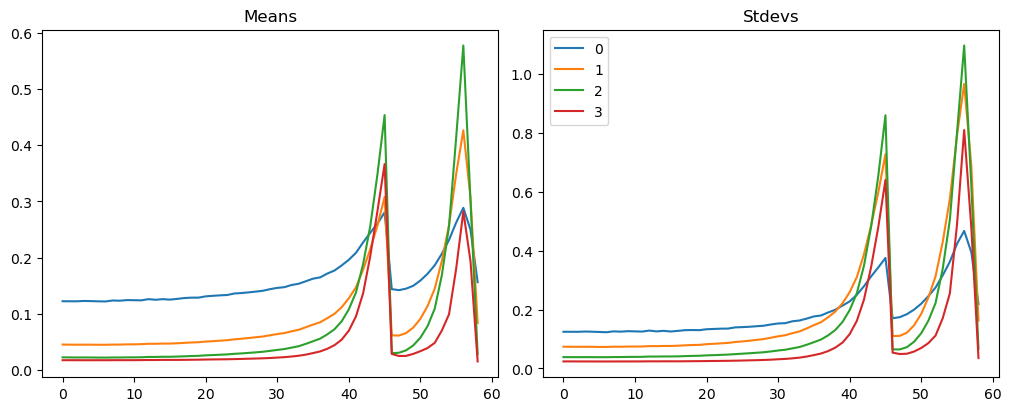

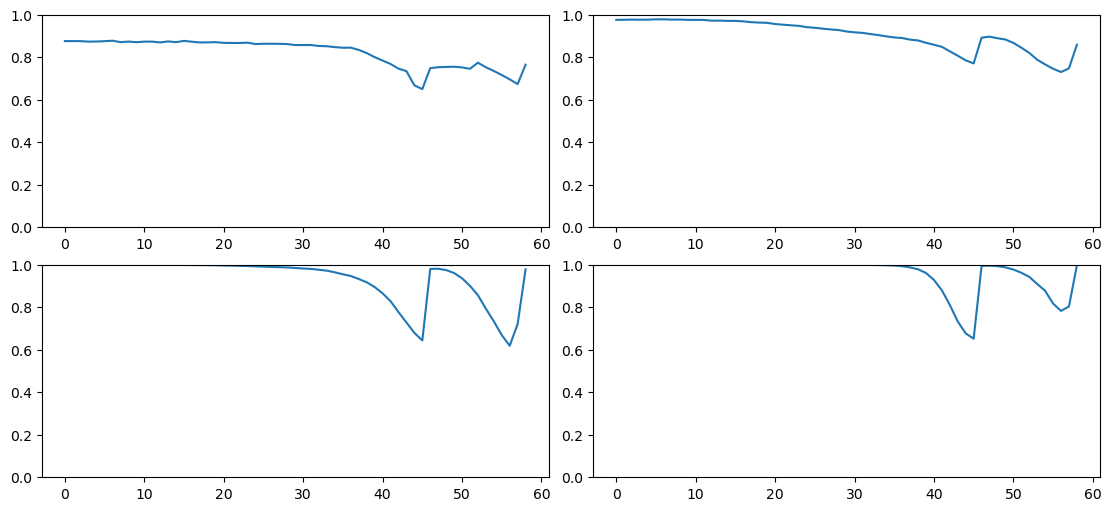

In [10]:
get_trainer(0.4).fit(1)
astats.plot_all()

### 0.1

epoch,train,loss,accuracy
0,train,2.3021,0.1275
0,eval,2.3007,0.1619


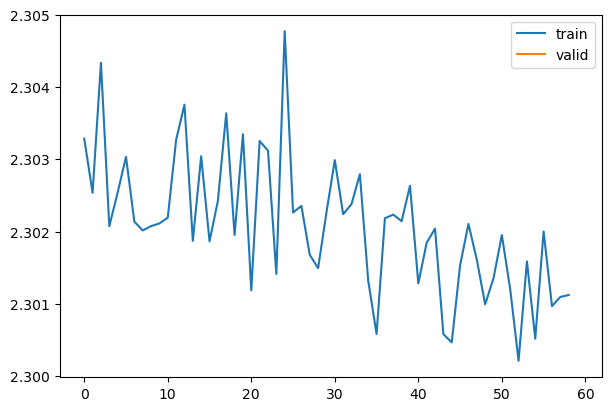

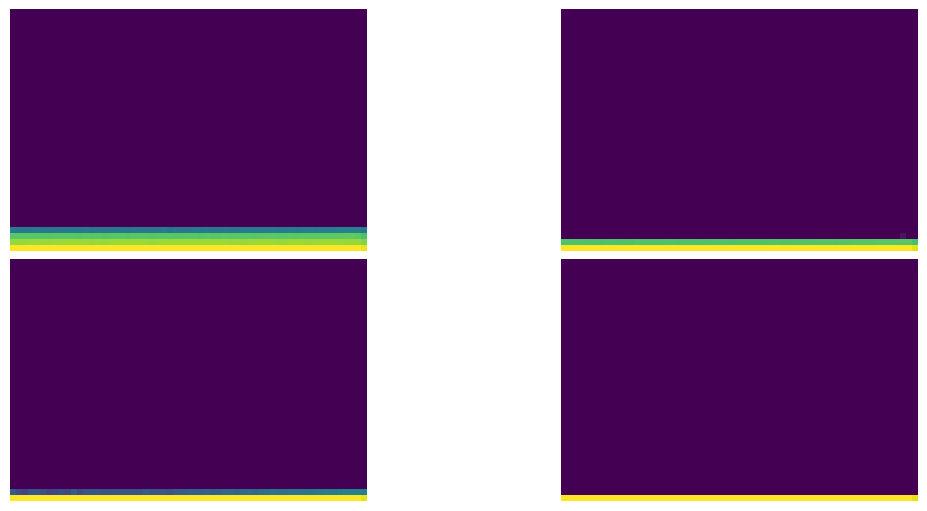

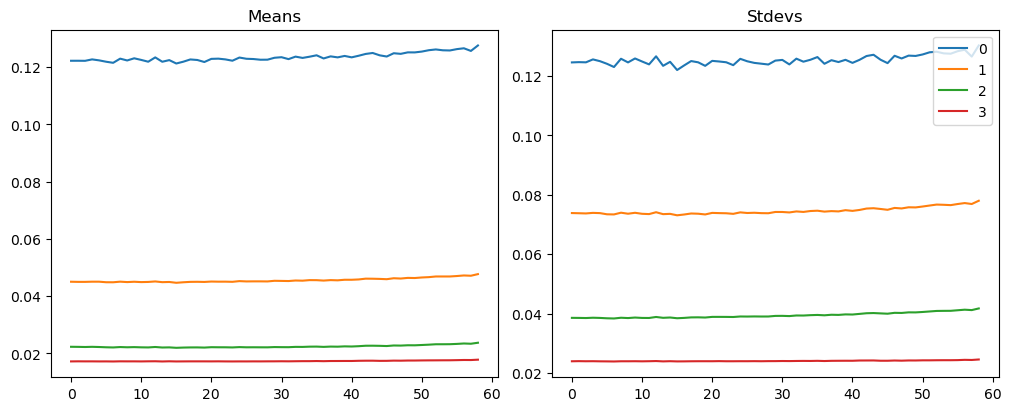

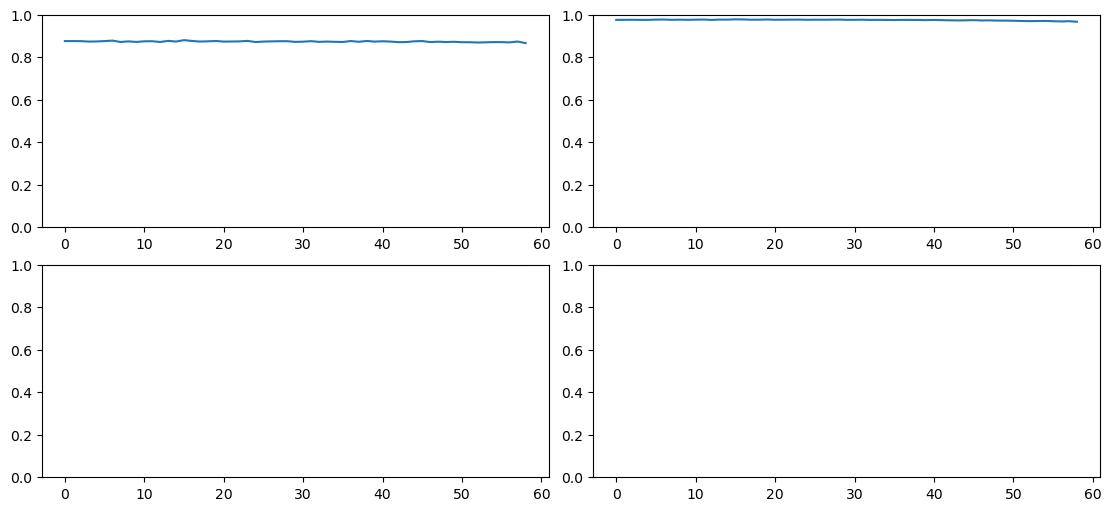

In [11]:
get_trainer(0.1).fit(1)
astats.plot_all()

### 0.2 (4 epochs)

epoch,train,loss,accuracy
0,train,2.3000,0.1159
0,eval,2.2908,0.1620
1,train,1.8752,0.3699
1,eval,1.0226,0.6022
2,train,0.8757,0.6713
2,eval,0.7620,0.7124
3,train,0.7179,0.7301
3,eval,0.6632,0.7494


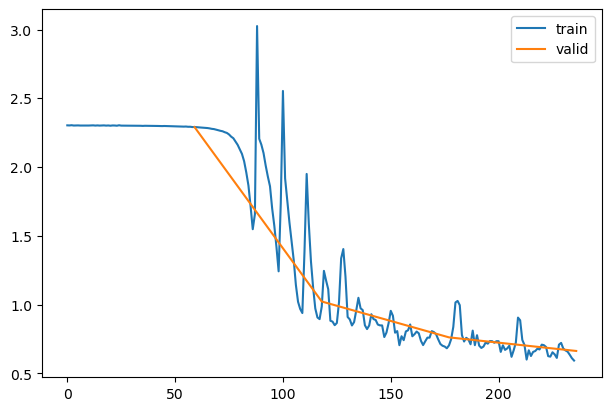

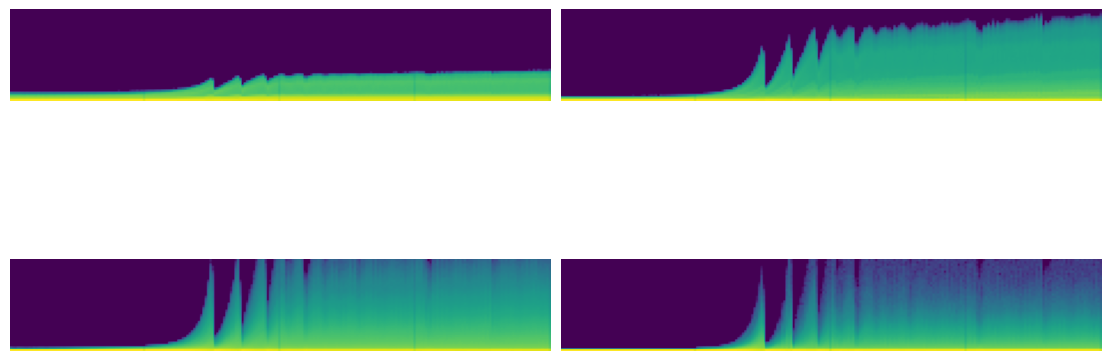

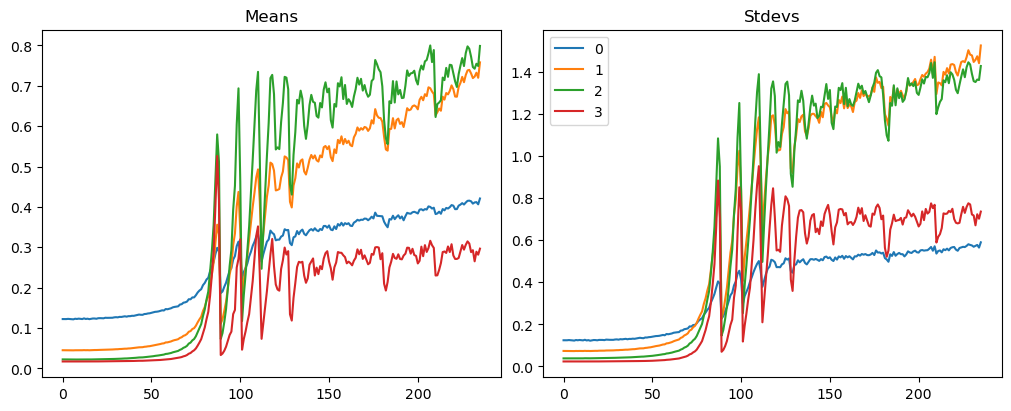

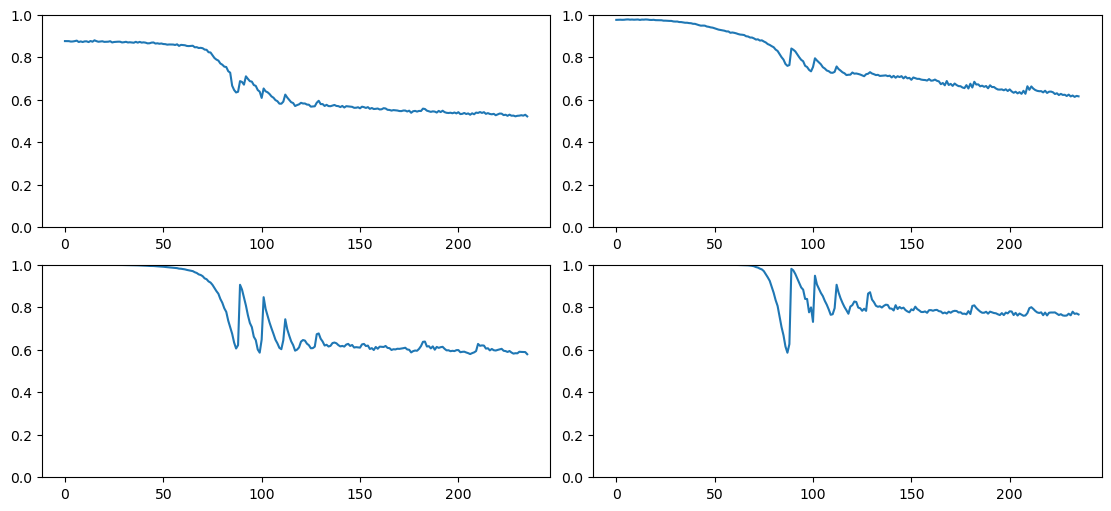

In [12]:
get_trainer(0.2).fit(4)
astats.plot_all()

## 0.2 1 batch

epoch,train,loss,accuracy
49,eval,1.1626,0.6075
99,eval,0.8888,0.7272
149,eval,0.6688,0.7542
199,eval,0.6609,0.7839
249,eval,0.7119,0.7821


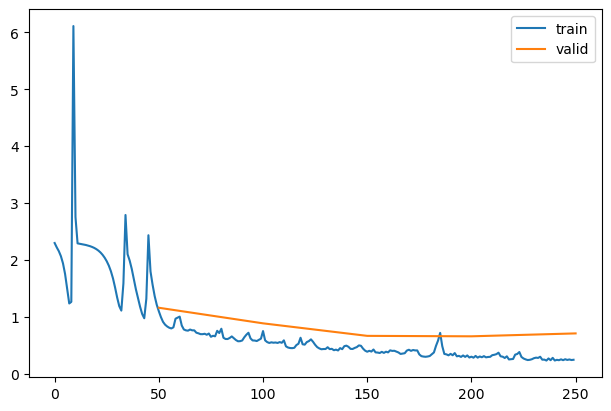

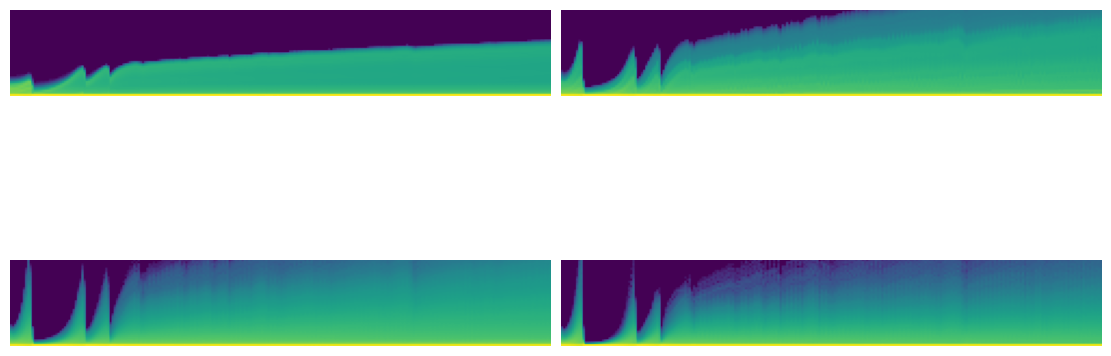

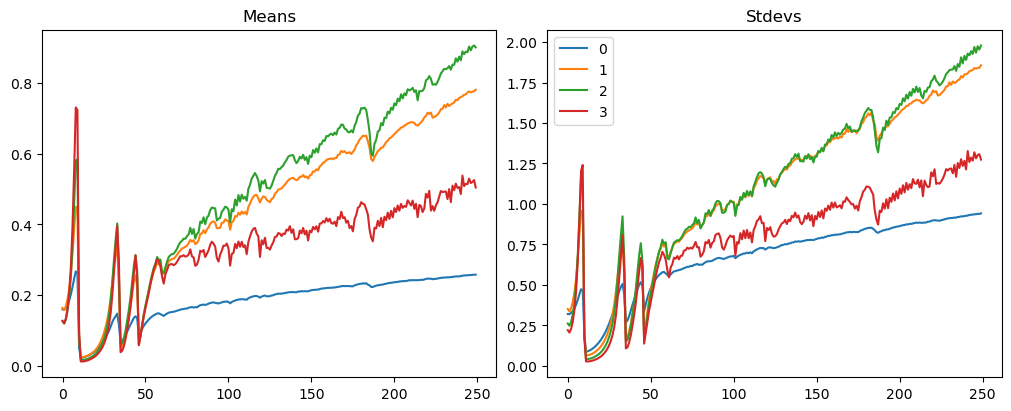

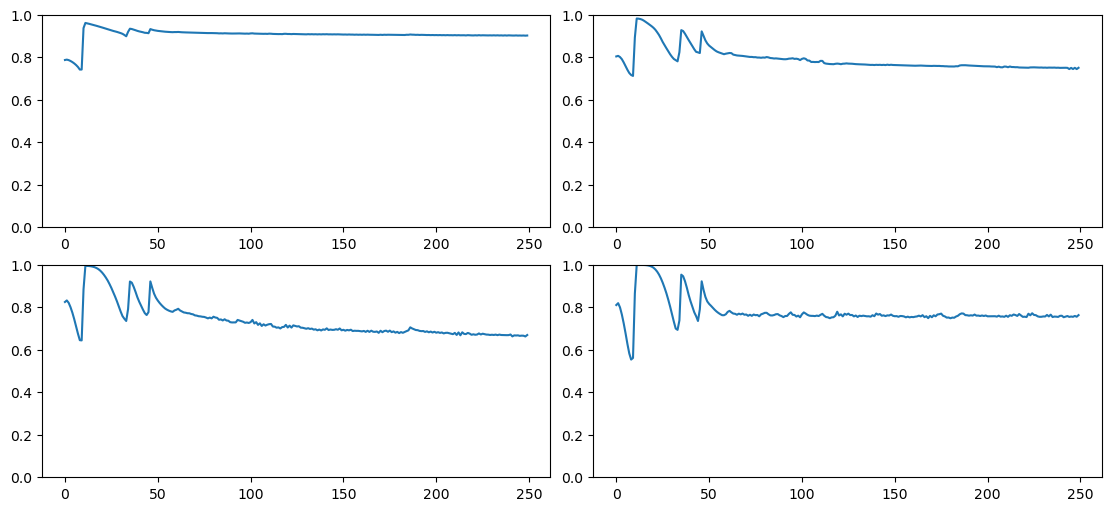

In [13]:
from tinyai.cbs import SingleBatchCB

learn = Trainer(get_model().apply(init_weights), dls, loss_func=cross_entropy, lr=0.2, cbs=cbs + [SingleBatchCB(50)])
learn.fit(250)
astats.plot_all()

## Weight Initialization

In [7]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [11]:
learn = Trainer(get_model().apply(init_weights), dls, loss_func=cross_entropy, lr=0.2, cbs=cbs)

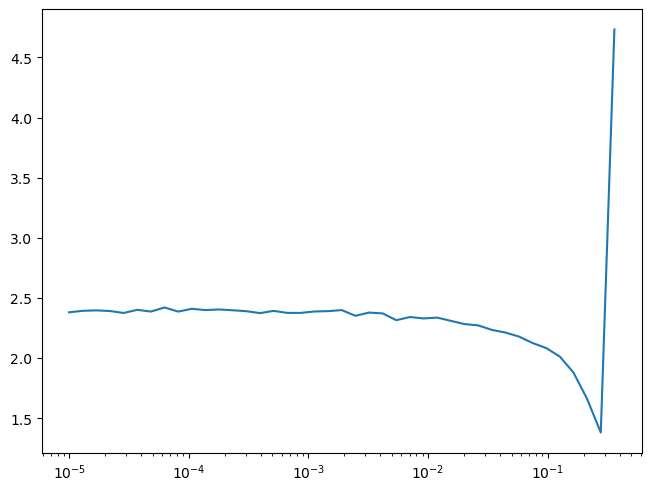

In [12]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,1.5757,0.5021
0,eval,1.1420,0.6261
1,train,0.7442,0.7311
1,eval,0.6299,0.7691
2,train,0.5984,0.7812
2,eval,0.6476,0.7549
3,train,0.5385,0.8026
3,eval,0.5301,0.8066


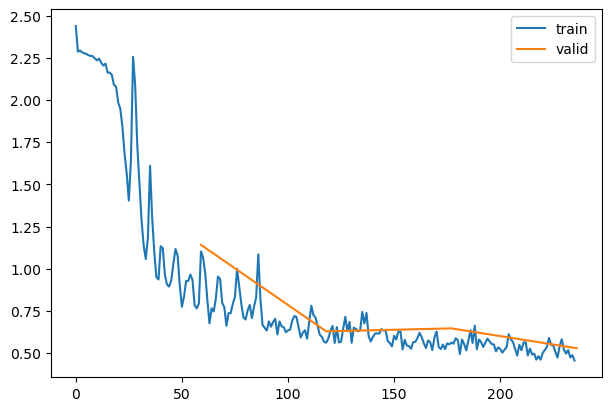

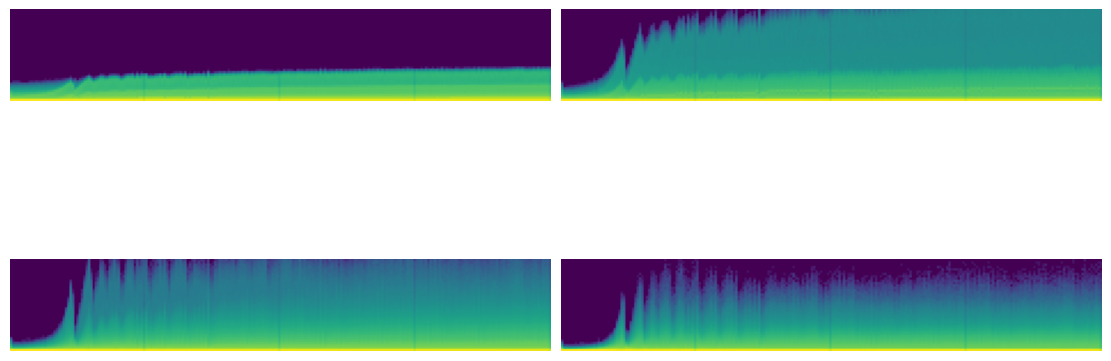

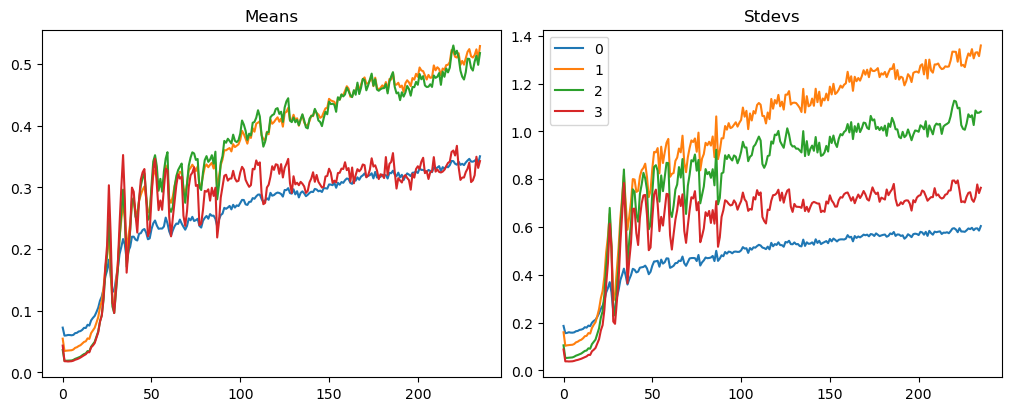

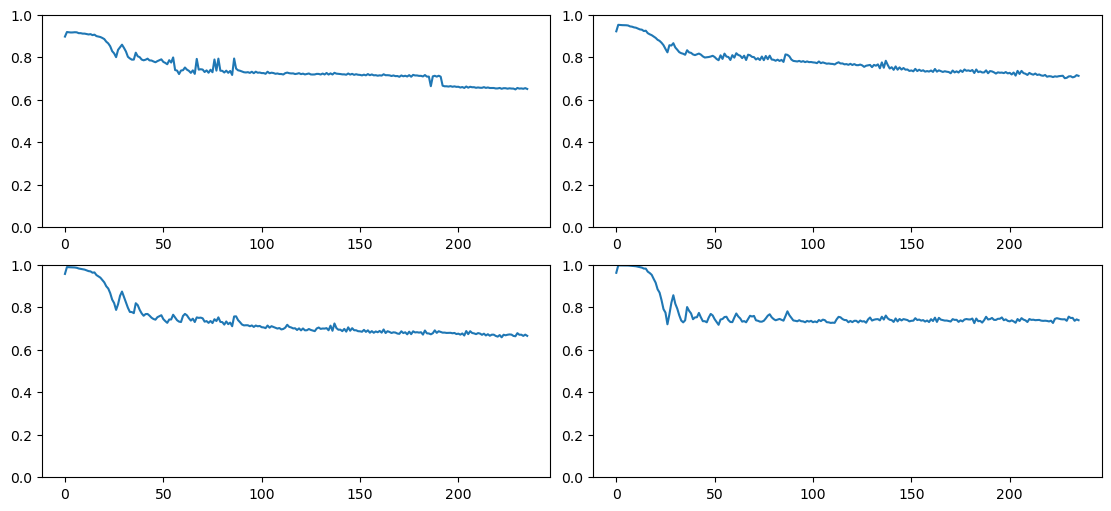

In [13]:
learn.fit(4)
astats.plot_all()

In [14]:
from tinyai.learner import Callback

class BatchTransformCB(Callback):
    def __init__(self, tfm): self.tfm = tfm

    def before_batch(self, learn):
        learn.batch = self.tfm(learn.batch)

In [15]:
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(0.283), tensor(0.354))

In [16]:
def bnorm(b):
    xb, y = b
    return (xb - xb.mean()) / xb.std(), y

In [17]:
xb, yb = bnorm(next(iter(dls.train)))
xb.mean(), xb.std()

(tensor(    0.000), tensor(1.))

In [18]:
from torch import optim

In [16]:
learn = Trainer(get_model().apply(init_weights), dls, loss_func=cross_entropy, lr=2e-3, cbs=cbs+[BatchTransformCB(bnorm)], opt_func=optim.AdamW)

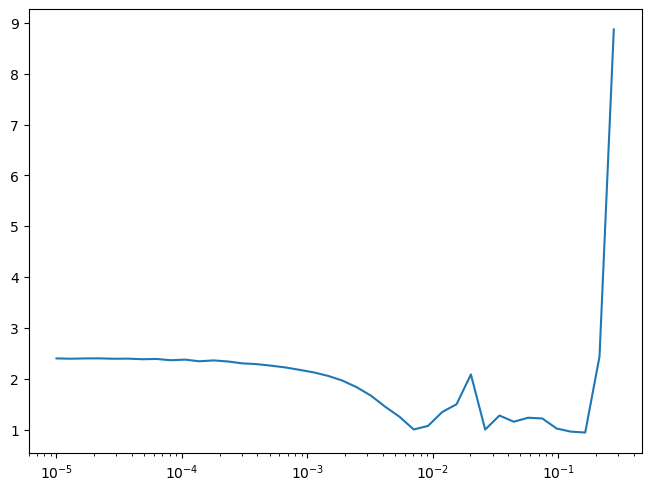

In [41]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,0.8403,0.7062
0,eval,0.5274,0.8031
1,train,0.4595,0.8326
1,eval,0.4569,0.8384
2,train,0.4049,0.8534
2,eval,0.4204,0.8480
3,train,0.3723,0.8644
3,eval,0.3964,0.8568
4,train,0.3486,0.8736
4,eval,0.3796,0.8634


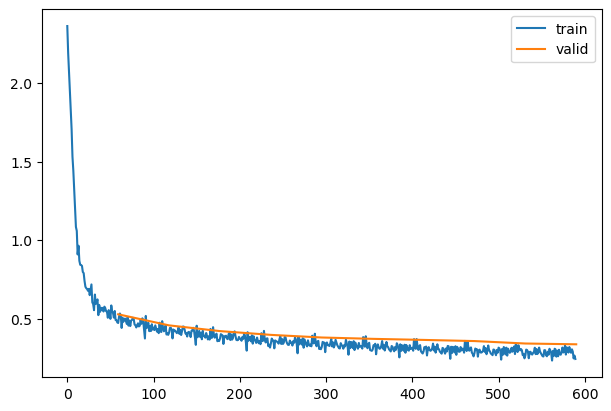

In [43]:
learn.fit(10)

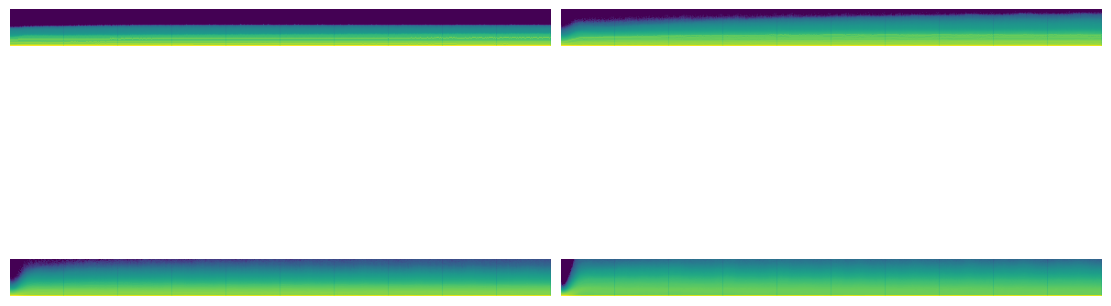

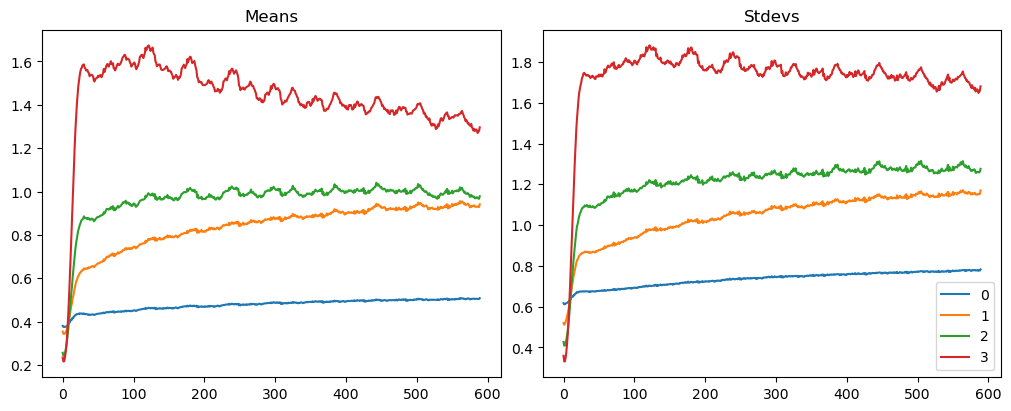

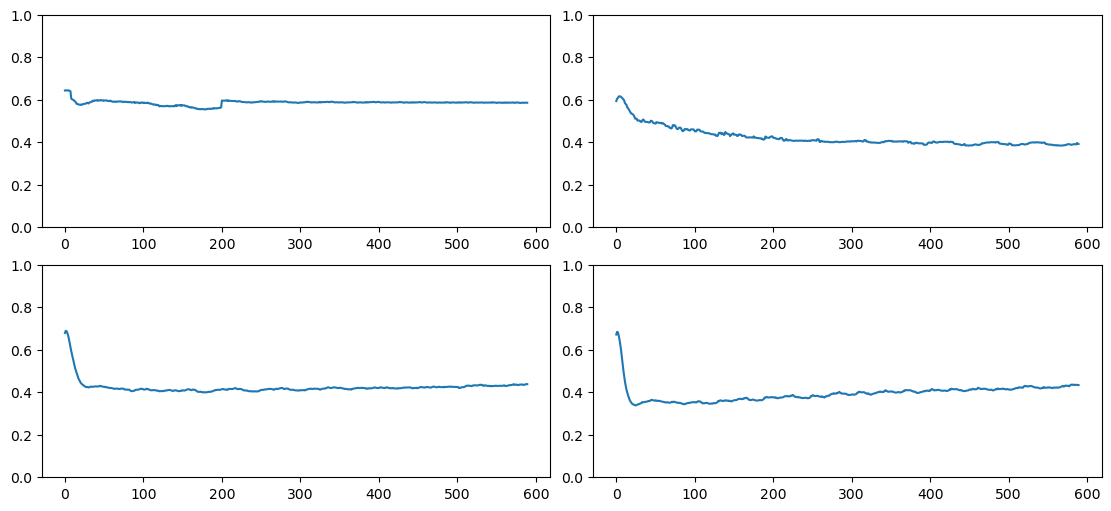

In [44]:
astats.plot_all()

In [19]:
import torch.nn.functional as F
from torch import nn

class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None): 
        super().__init__()
        fc.store_attr()

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub  is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, a=leaky)
        nn.init.zeros_(m.bias)
    

In [20]:
from tinyai.conv import conv

def get_model(nfs=None, act=nn.ReLU, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=None), nn.Flatten())


In [29]:
from functools import partial
from tinyai.learner import BatchTransformCB

iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [metrics, astats]
model = get_model(act=act_gr).apply(iw)
sd_gt = learn.model.state_dict().copy()

learn = Trainer(model, dls, loss_func=cross_entropy, lr=2e-3, cbs=cbs + [BatchTransformCB(bnorm)], opt_func=optim.AdamW)

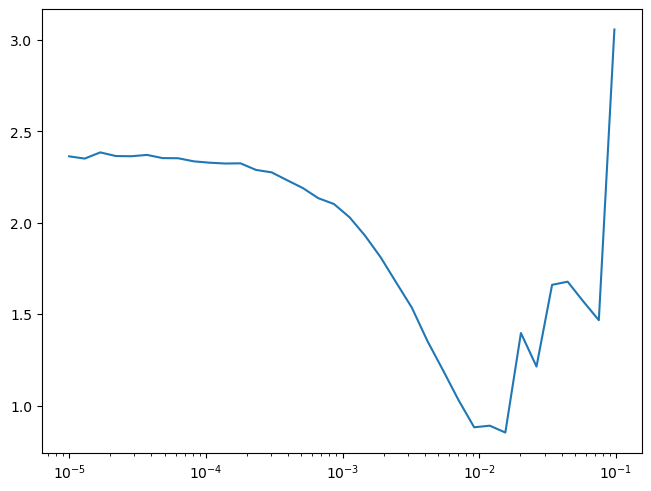

In [30]:
learn.lr_find()

epoch,train,loss,accuracy
0,train,1.1953,0.7319
0,eval,0.5889,0.7865
1,train,0.5050,0.8168
1,eval,0.5018,0.8176
2,train,0.4418,0.8408
2,eval,0.4587,0.8339
3,train,0.4048,0.8536
3,eval,0.4309,0.8446


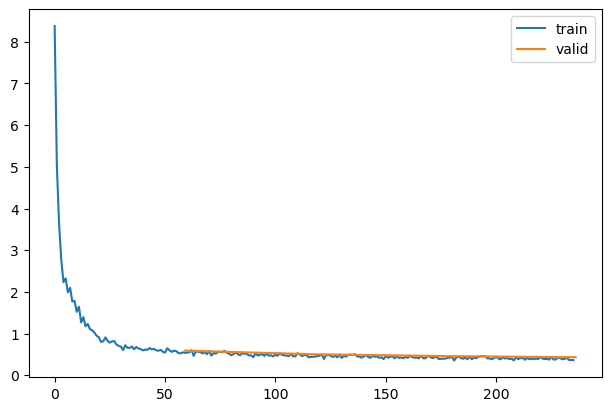

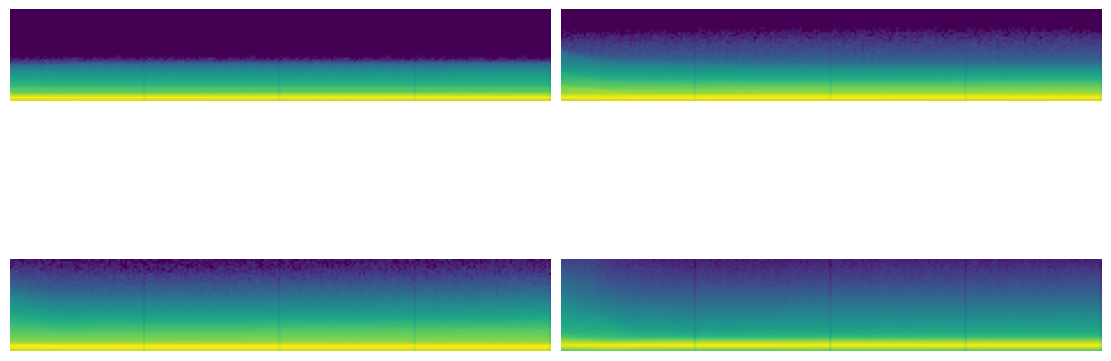

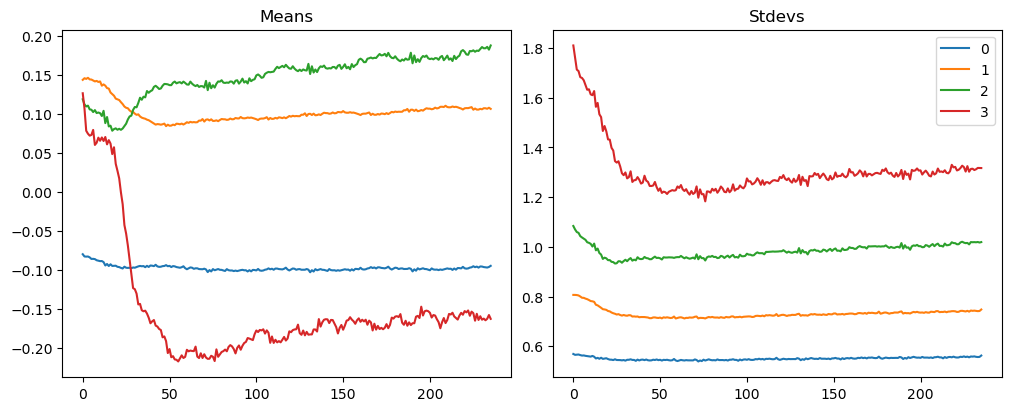

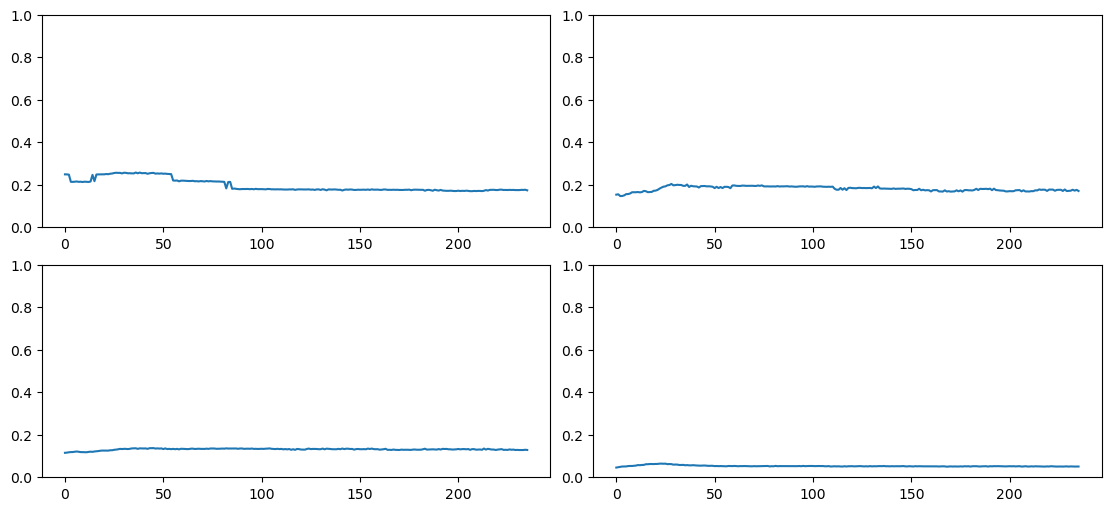

In [31]:
learn.fit(4)
astats.plot_all()

## 90% Accuaracy

In [32]:
dls = DataLoaders.from_dd(tds, batch_size=256, num_workers=4)

In [34]:
set_seed(42)
get_model().apply(iw)
iw = partial(init_weights, leaky=0.1)
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)

astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [metrics, astats]

model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Trainer(model, dls, loss_func=cross_entropy, lr=3e-3, cbs=cbs, opt_func=optim.AdamW)

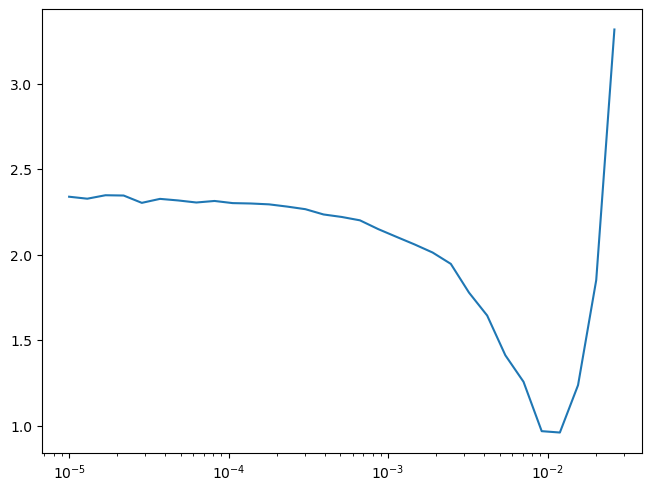

In [35]:
learn.lr_find()


epoch,train,loss,accuracy
0,train,0.4655,0.8306
0,eval,0.4181,0.8493
1,train,0.3509,0.8714
1,eval,0.3776,0.8648
2,train,0.3132,0.8847
2,eval,0.3591,0.8727


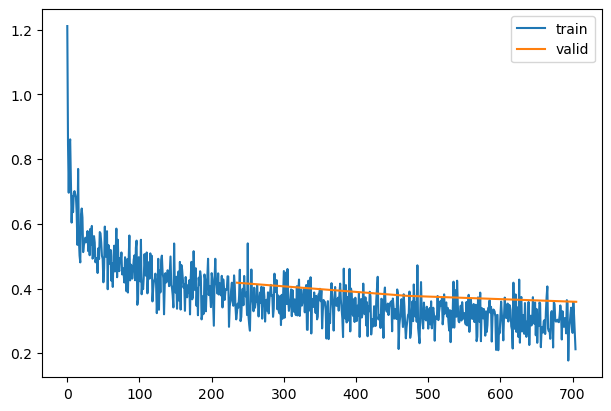

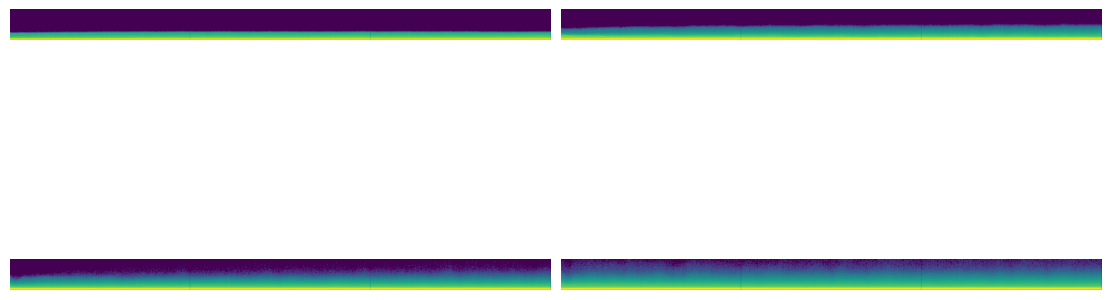

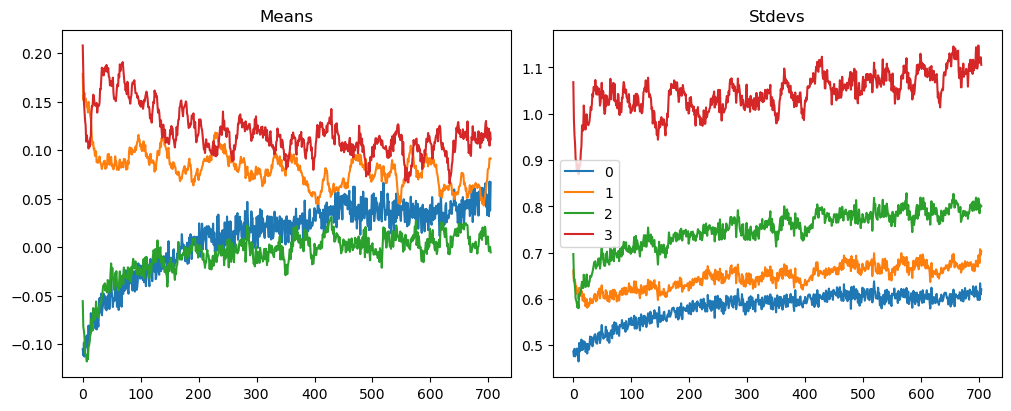

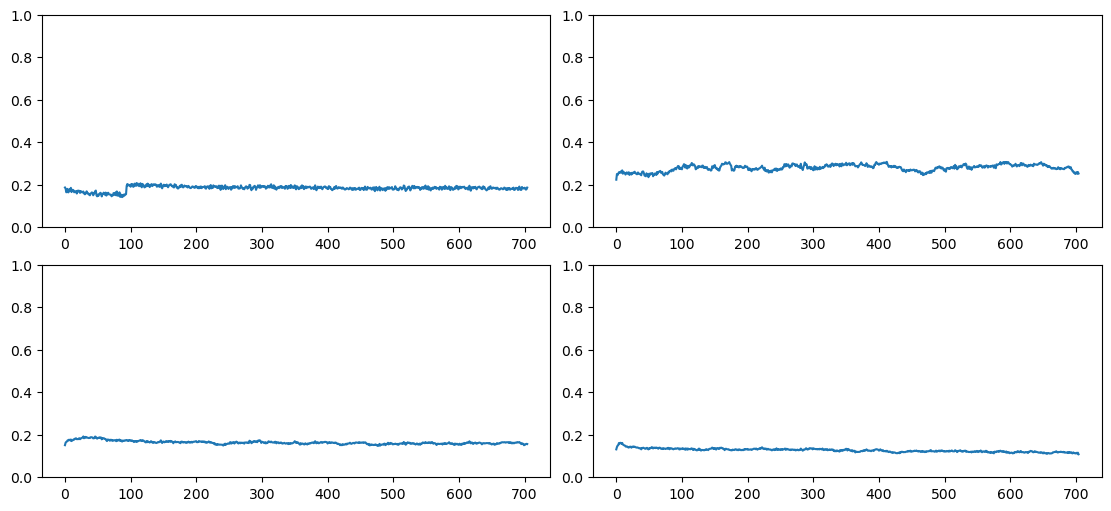

In [36]:
learn.fit(3)
astats.plot_all()

epoch,train,loss,accuracy
0,train,0.2635,0.9036
0,eval,0.3126,0.8892
1,train,0.2528,0.9082
1,eval,0.3092,0.8905
2,train,0.2459,0.9104
2,eval,0.3063,0.8926


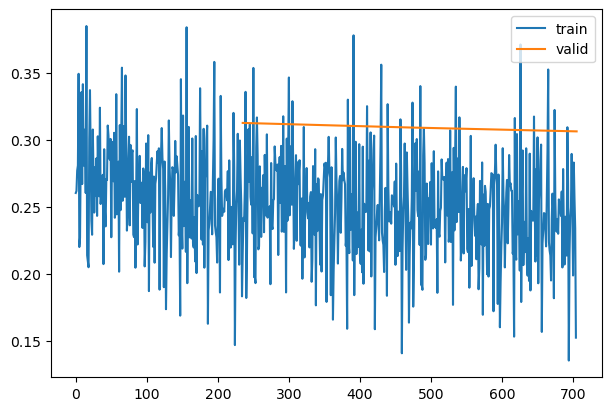

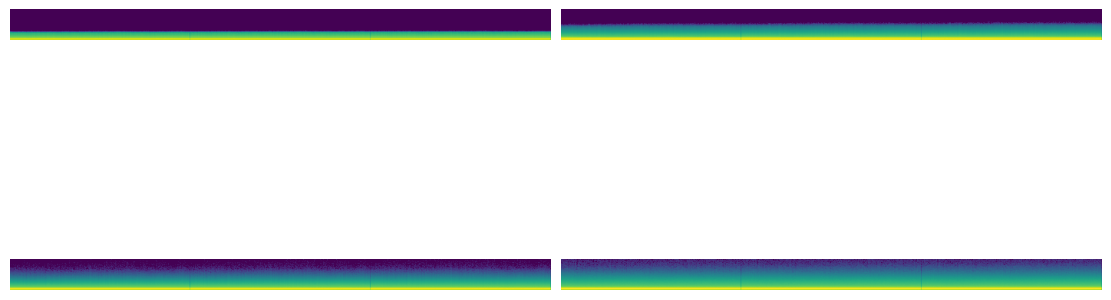

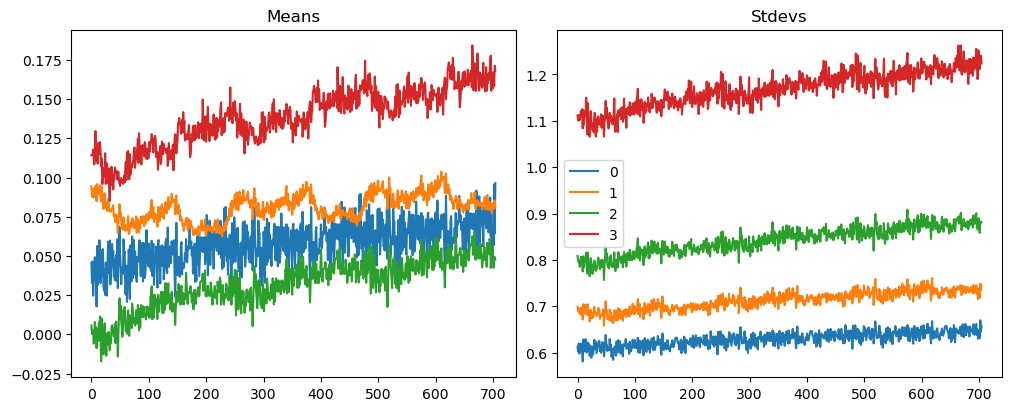

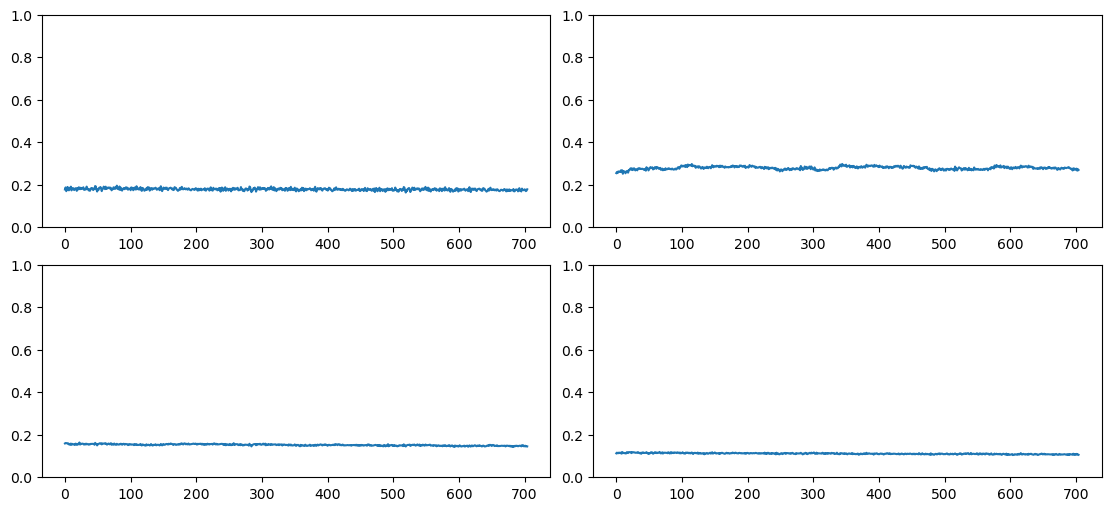

In [37]:
learn.fit(3, lr=5e-4)
astats.plot_all()